# Exploratory Data Analysis
The dataset did not come with documentation or detailed descriptions of the features. Therefore, I had to infer the meaning and purpose of each feature based on its name and observed patterns in the data.

In [ ]:
import sys
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

# Add the root path to sys.path
root_path = Path().resolve().parent
sys.path.append(str(root_path))

# Hide warnings
warnings.filterwarnings("ignore")

## Data Loading

In [15]:
# Load data and clean data
data_df = pd.read_parquet(root_path / "data" / "processed" / "search_sample_data.parquet")

## Summary Statistics

In [16]:
# Make a copy to the original dataframe for analysis only
analysis_df = data_df.copy()
analysis_df[['click', 'add_to_cart', 'conversion']] = analysis_df[['click', 'add_to_cart', 'conversion']].replace({0: 'No', 1: 'Yes'})

def describe_df(df: pd.DataFrame):
    # Replace empty strings with NaN
    df.replace("", np.nan, inplace=True)

    # Descriptive statistics
    temp = df.describe(include="all").drop(["count", "unique"]).T.fillna("-")
    temp.insert(loc=0, column='Dtype', value=[df[f].dtype for f in df])
    temp.insert(loc=1, column='nunique', value=df.nunique())
    temp.insert(loc=2, column='5 unique samples', value=[df[f].unique()[:5] for f in df])
    temp.insert(loc=3, column='nulls', value=df.isnull().sum())
    temp.insert(loc=4, column='nulls%', value=df.isnull().mean() * 100)
    temp = temp.style.background_gradient(cmap='Reds', axis=0).format(precision=2)

    return temp

describe_df(analysis_df)

,Dtype,nunique,5 unique samples,nulls,nulls%,top,freq,mean,min,25%,50%,75%,max,std
time,datetime64[ms],66063,"['2023-10-25 00:00:00.239000', '2023-10-25 00:00:04.782000', '2023-10-25 00:00:09.976000', '2023-10-25 00:00:13.436000', '2023-10-25 00:00:19.230000'] Length: 5, dtype: datetime64[ms]",0,0.00,-,-,2023-10-30 02:42:08.604000,2023-10-25 00:00:00.239000,2023-10-27 14:19:21.592000,2023-10-30 04:22:31.149000,2023-11-01 18:27:23.707000,2023-11-03 23:59:57.489000,-
user_id,object,36139,['0128154c352c99728ee8751b4195edf1' 'be5a2be5ba0512cd2760d238db4ab081' '429aaefb44eec755f343cbf11a1c5e35' '984bc819922189826223473d93c1eb05' 'b7485193f4e7f5b8ac3c94f71f4456a9'],0,0.00,5e3d4b4e9fe3d0b2c141545df152d248,99,-,-,-,-,-,-,-
product_id,object,9291,['b718927467331a24416eff42b2de0baa' 'b3f3f61b98f0fb22f7ec1c4bc1134047' '6bf216c19a268e5526e7dac82bf97075' '53ebf70c18f22c5bca530cf6baa0a362' '348f161dc5118d0981244cd24e95427f'],0,0.00,f8cae79a13f055aef7f494d750c85fdf,438,-,-,-,-,-,-,-
merchant_id,object,851,['7a759c49dbfa76d5f6a37bc92672d4ab' '018c7a5ba47ad79a8c58b0ee5695d62c' '293e73158ae0ec24bda7ddecf0368094' '8ecd51f99303ef15f7851db6d0447d15' 'e5f068e9b1f03449fe6e67a931ce84e0'],0,0.00,dc9b8b5db6bf249c30a04fa99be3de43,1623,-,-,-,-,-,-,-
category_id,object,329,['eae2be8310696802d013f0053cefa26b' '35a55705fa967b51b55bc1956fe69e19' '701e4d9be4e0679c5d1ffa62a0d0b1f8' 'faefe0110e721dc3ea7df010e66ce59f' '1b873b70b598b2b8870726342334ac18'],0,0.00,d332ed8693caa0ed046759d7f3983748,5552,-,-,-,-,-,-,-
channel,object,16,['Paid Social' 'Paid Search - Brand' 'Organic' 'Email - Transactional' 'Affiliate'],0,0.00,Direct,46000,-,-,-,-,-,-,-
query_text,object,15246,['princess cake' 'crab legs' 'chicago' 'rye bread' 'pizza'],192,0.15,thanksgiving dinners,1721,-,-,-,-,-,-,-
device_type,object,7,['Mobile' 'Desktop' 'Phablet' 'Tablet' nan],428,0.32,Mobile,70360,-,-,-,-,-,-,-
sales_last_week,int64,42,[11 5 9 12 2],0,0.00,-,-,7.36,0.00,4.00,7.00,10.00,41.00,4.13
sales_last_month,int64,59,[12 8 10 15 2],0,0.00,-,-,9.70,0.00,6.00,9.00,12.00,58.00,5.83


Key Insights:
- There is only one week of data available (from 25-10-2023 to 03-11-2023).
- It isn't clear to whose variable belong `sales_last_week`, `sales_last_month`, `sales_last_year`, `previous_purchase`, if it's related to the merchant, to the product, or to the category. 
- I don't understand the meaning of the `editor_pick` feature.
- Some features have nulls, but there represents less than 1% of the data in most of them.
- `merchant_region` has the most nulls. But this values can be imputed from `merchant_state`, which has not nulls.
- The most query search is *thanksgiving dinners*.
- *Carrot Cake* is the most popular product.
- *Russ & Daughters* is the most popular merchant.
- *New York* is the most popular merchant city.

## Distributions

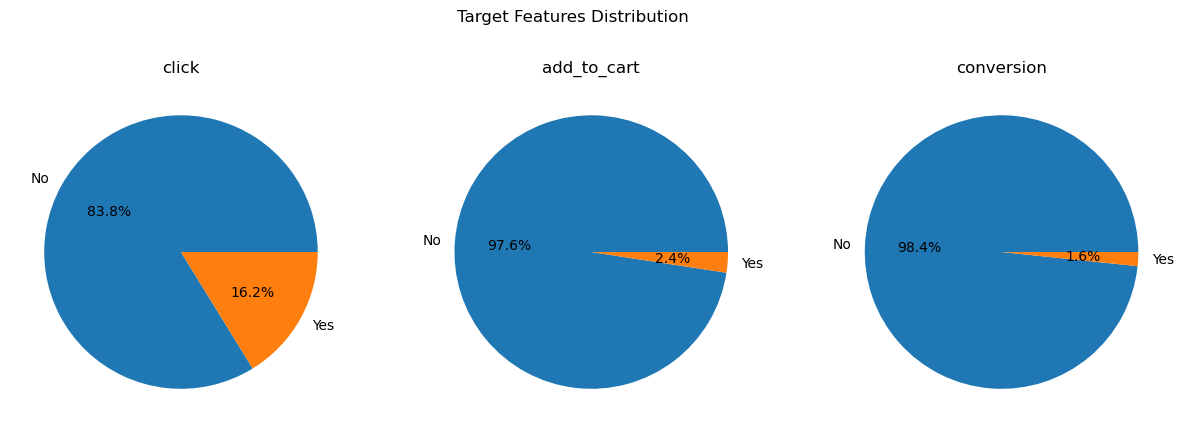

In [17]:
# Target features distribution
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Target Features Distribution')
for i, feature in enumerate(['click', 'add_to_cart', 'conversion']):
    analysis_df[feature].value_counts().plot(kind='pie', ax=ax[i], autopct='%1.1f%%')
    ax[i].set_title(feature)
    ax[i].set_ylabel('')

Like I expected, clicks, add-to-cart and conversions (purchases) are **sparse**.

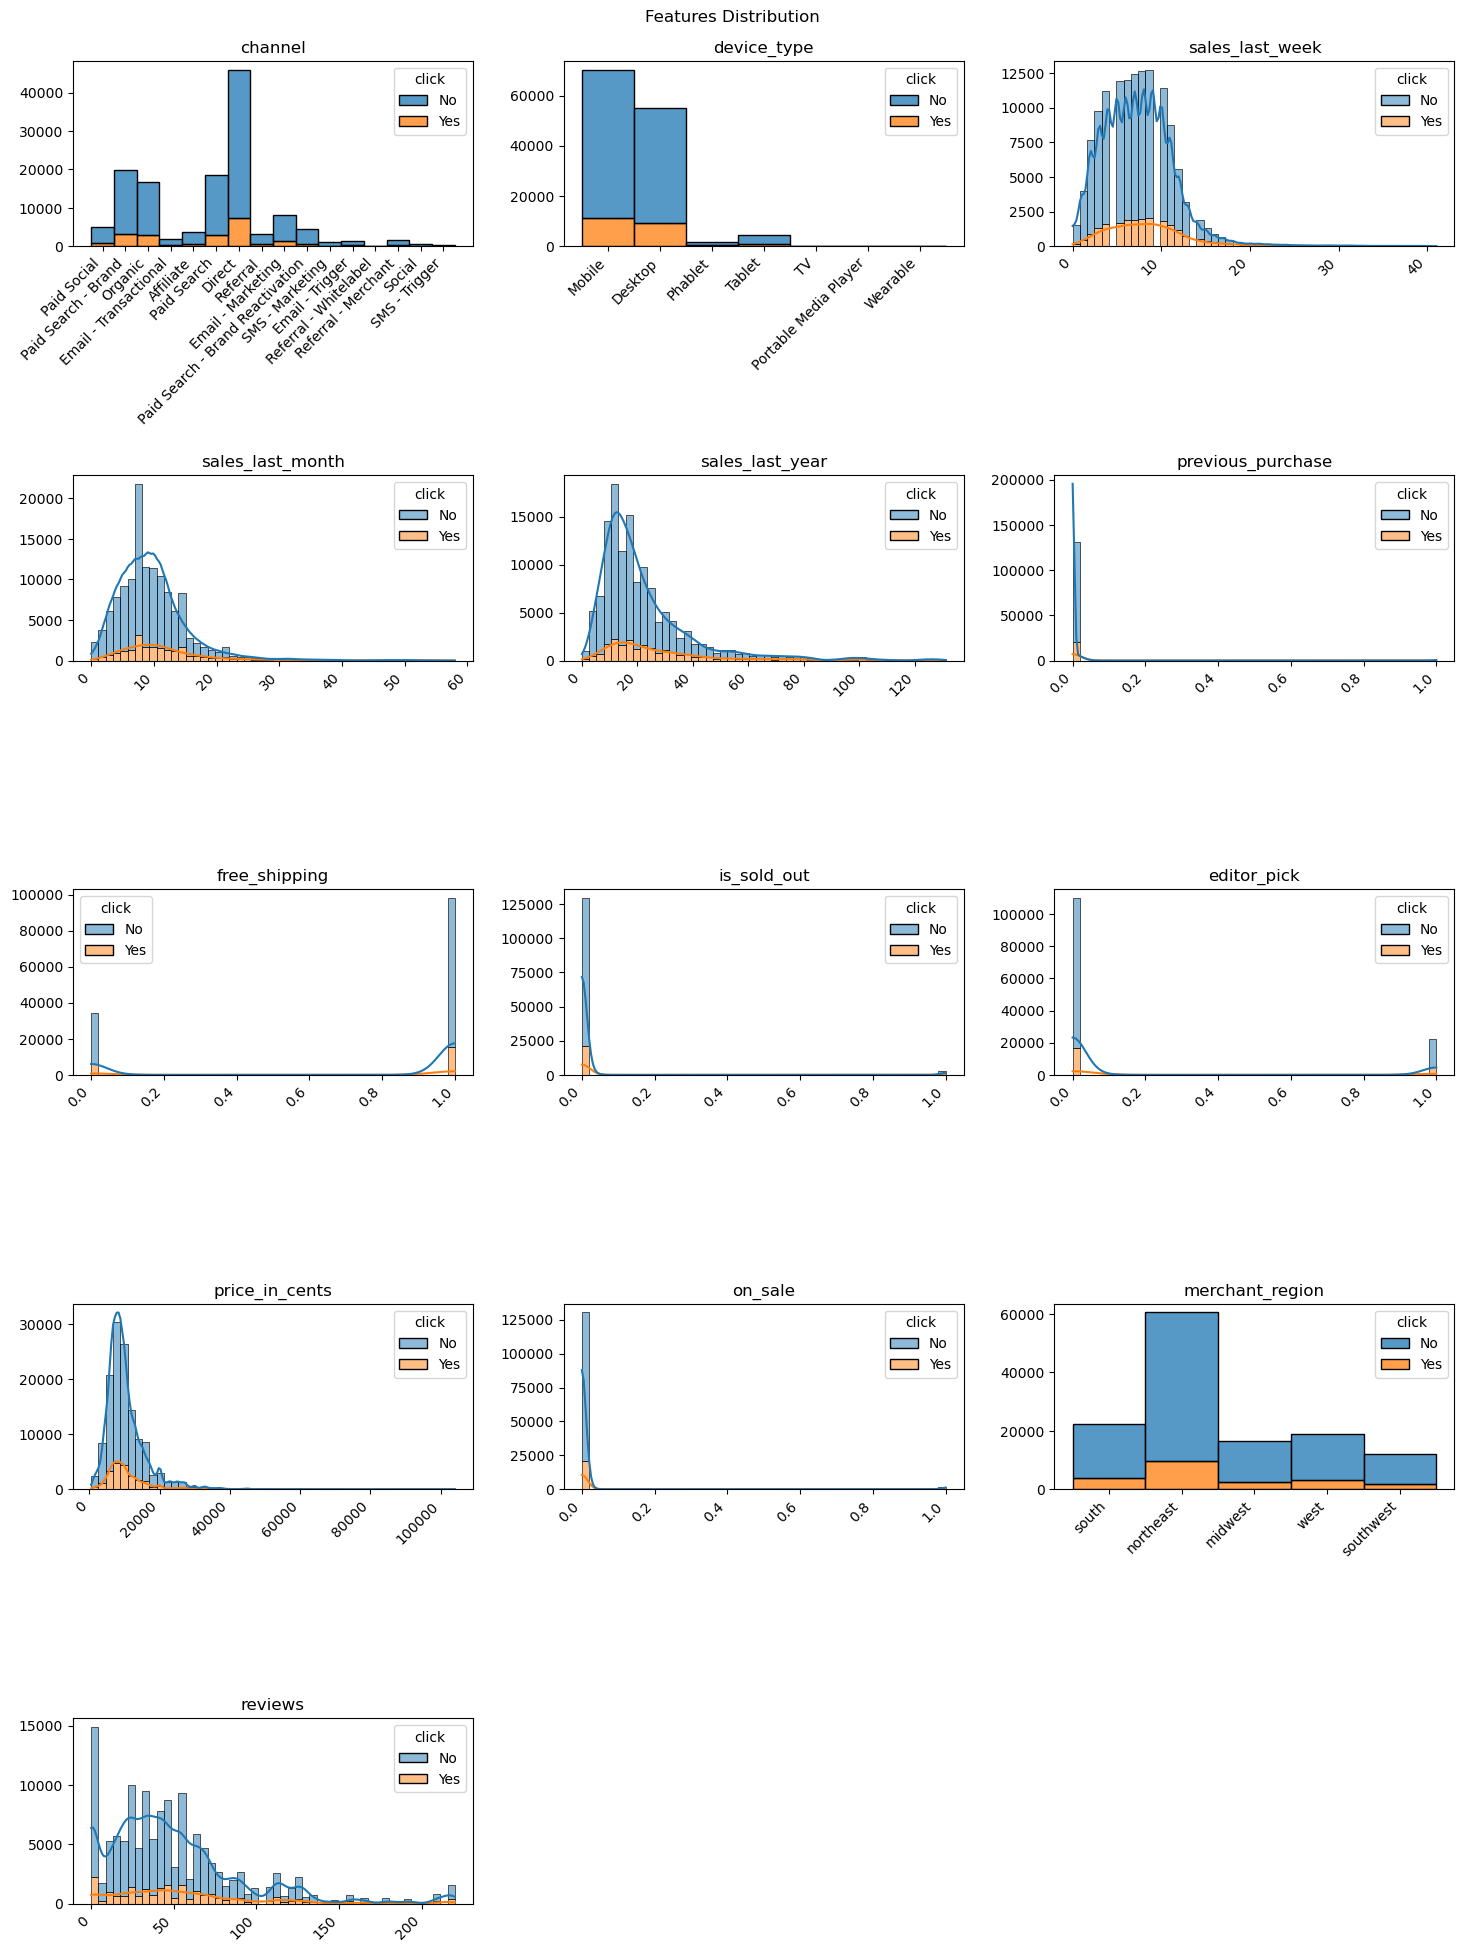

In [18]:
# I won't see distributions of features that contain high cardinality
cols_to_drop = [
    'time', 'user_id', 'product_id', 'merchant_id', 'category_id',
    'query_text', 'merchant_name', 'product_name', 'category_name', 'merchant_city',
    'merchant_state'
]

# Display Distributions
def display_distributions(df: pd.DataFrame, cols: list[str] = None, target: str = None):
    df = df.drop(cols, axis = 1)
    features = df.drop(target, axis=1).columns
    rows = len(features) // 3 if len(features) % 3 == 0 else len(features) // 3 + 1    
    
    fig, axes = plt.subplots(rows, 3, figsize=(15, 20))
    for i, feature in enumerate(features):
        ax = axes.ravel()[i]
        sns.histplot(
            df,
            x=feature,
            hue=target,
            multiple="stack",
            ax=ax, bins=50,
            kde=True if df[feature].dtype not in ['O', 'category'] else False
        )
        
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title(feature)

        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha('right')
    
    # Hide any unused axes
    for j in range(len(features), len(axes.ravel())):
        axes.ravel()[j].set_visible(False)
    
    fig.suptitle('Features Distribution')
    plt.tight_layout(pad=2 )
    plt.show()


display_distributions(analysis_df, cols= cols_to_drop + ['add_to_cart', 'conversion'], target= 'click')

Key Insights:
- *Direct* is the most popular `channel`.
- *Mobile* and *Desktop* are the most popular `device_type`.
- `sales_last_week`, `sales_last_month`, `sales_last_year`, `price_in_cents` and `reviews` are **left-skewed**.
- Most of the products have *free shipping*.
- `previous_purchase`, `is_sold_out`, `editor_pick` and `on_sale` are highly **skewed**.

## Correlations

In [19]:
def correlation(df:pd.DataFrame=None, cols: list=[str]):
    df = df.drop(cols, axis=1)
    not_number = df.select_dtypes(exclude='number').columns
    # Factorize categorical features
    df[not_number] = df[not_number].apply(lambda x: pd.factorize(x)[0])
    correlation_matrix = df.corr(numeric_only=True)
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    correlation_matrix = correlation_matrix.mask(mask)
    return px.imshow(correlation_matrix,
            labels=dict(color="Correlation"),
            x=correlation_matrix.index,
            y=correlation_matrix.columns,
            color_continuous_scale='Viridis').update_layout(title="Features Correlation", width = 800, height= 700)

correlation(analysis_df, cols= cols_to_drop + ['merchant_region'])

Key Insights:
- `sales_last_week`, `sales_last_month`, `sales_last_year` are highly **correlated** between them and with `editor_pick` and `reviews`.
- target features `click`, `add_to_cart`, `conversion` are **highly correlated** as expected.
- `price_in_cents` and `free_shipping` are **slightly positive correlation**. That means if the price of an item is higher, it's more likely to have free shipping.
- interesting **negative correlation** between `free_shipping` and `reviews`.
- **slightly negative correlation** between `price_in_cents` and `reviews` indicating that if a product is expensive, it's more likely to have fewer reviews.

## Word Cloud

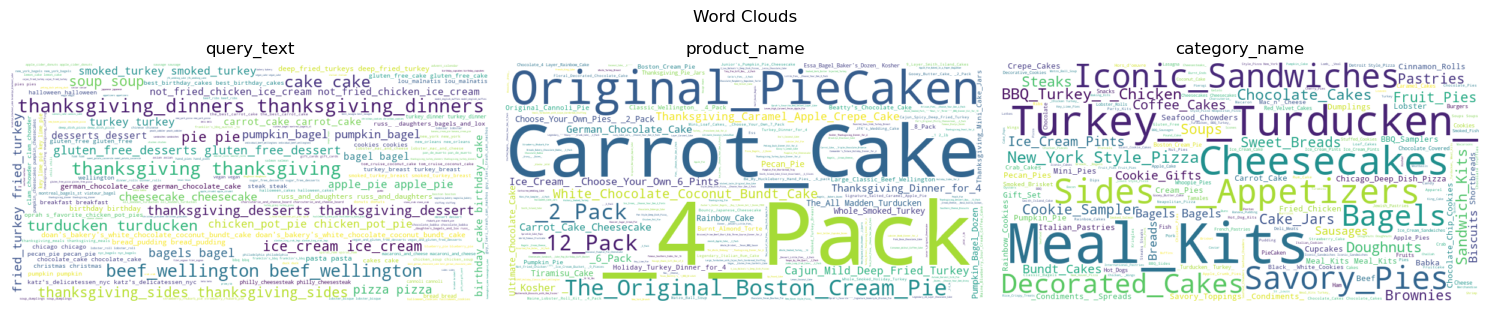

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(['query_text', 'product_name', 'category_name']):
    text = analysis_df[feature].dropna().apply(lambda x: x.replace(" ", "_")).str.cat(sep=" ")
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax[i].imshow(wordcloud, interpolation='bilinear')  # Display the word cloud image
    ax[i].axis("off")  # Turn off the axis
    ax[i].set_title(feature)

fig.suptitle('Word Clouds')
plt.tight_layout(rect=[0, 0.03, 1, 1.3])  # Adjust layout to make space for suptitle
plt.show()  

## Outliers

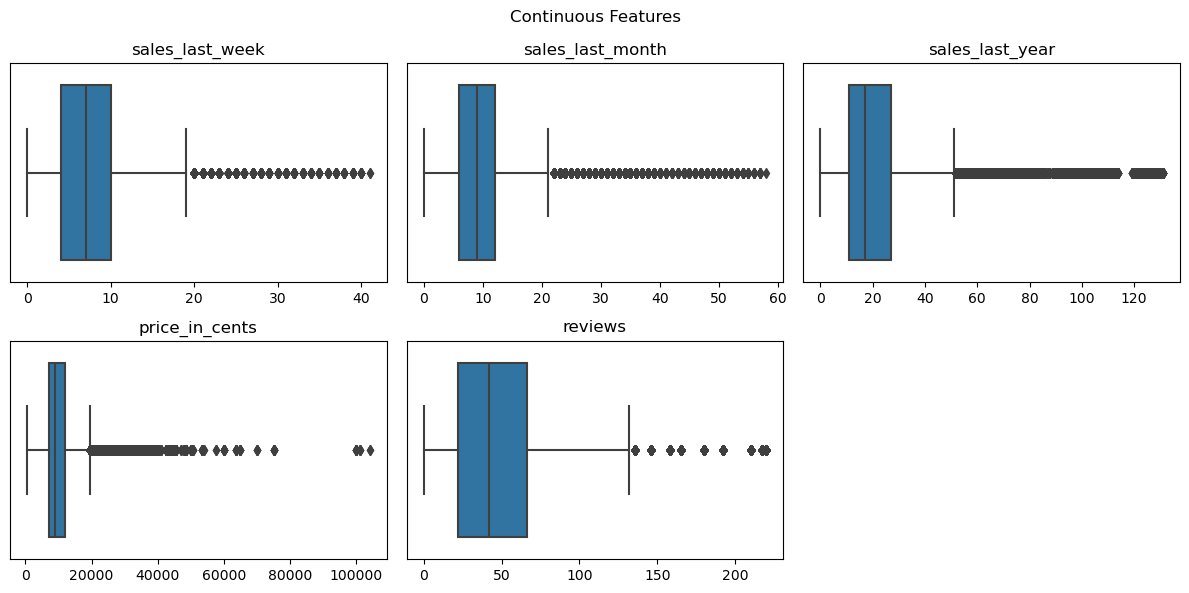

In [21]:
continuous_features = ["sales_last_week", "sales_last_month", "sales_last_year", "price_in_cents", "reviews"]

fig, ax = plt.subplots(2,3, figsize=(12, 6))
for i, feature in enumerate(continuous_features):
    axes = ax.flatten()
    sns.boxplot(data_df[feature], ax=axes[i], orient='h')
    axes[i].set_title(feature)
    axes[i].set_yticks([])
for j in range(len(continuous_features), len(axes)):
    axes[j].set_visible(False)
plt.suptitle("Continuous Features")
plt.tight_layout()
plt.show()

There are outliers, so it'll be necessary to clip them.